In [1]:
# Calling third-party libraries
import os
import io
import base64
import datetime     
import calendar      
import time
import re 
import folium
import webbrowser

#Data processing
import pandas as pd
from dateutil import parser
import numpy as np
import math

#MachineLearning
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import sklearn
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import r2_score


warnings.filterwarnings("ignore")

In [3]:
# Do the same for the test set
test_df = pd.read_csv('test.csv')
test_fr = pd.read_csv ('fastest_routes_test.csv' )
test_fr_new = test_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
test_df = pd. merge (test_df, test_fr_new, on = 'id', how = 'left' )
test_df.head ()

test_data = test_df.copy()
test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime)
test_data.loc[:, 'pick_month'] = test_data['pickup_datetime'].dt.month
test_data.loc[:, 'hour'] = test_data['pickup_datetime'].dt.hour
test_data['week_of_year'] = test_data['pickup_datetime'].dt.isocalendar().week
test_data.loc[:, 'day_of_year'] = test_data['pickup_datetime'].dt.dayofyear
test_data.loc[:, 'day_of_week'] = test_data['pickup_datetime'].dt.dayofweek

def haversine_(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b
import math

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

test_data.loc[:,'hvsine_pick_drop'] = haversine_(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
test_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
test_data.loc[:,'bearing'] = bearing_array(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)

#空间的聚类	
def assign_cluster(df, k):
    test_pick = test_df[['pickup_longitude', 'pickup_latitude']]
    test_drop = test_df[['dropoff_longitude', 'dropoff_latitude']]
    
    # 固定初始化中心，注意：初始化中心数量应与 k 保持一致
    init = np.array([
        [ -73.98737616,  40.72981533],
        [-121.93328857,  37.38933945],
        [ -73.78423222,  40.64711269],
        [ -73.9546417 ,  40.77377538],
        [ -66.84140269,  36.64537175],
        [ -73.87040541,  40.77016484],
        [ -73.97316185,  40.75814346],
        [ -73.98861094,  40.7527791 ],
        [ -72.80966949,  51.88108444],
        [ -76.99779701,  38.47370625],
        [ -73.96975298,  40.69089596],
        [ -74.00816622,  40.71414939],
        [ -66.97216034,  44.37194443],
        [ -61.33552933,  37.85105133],
        [ -73.98001393,  40.7783577 ],
        [ -72.00626526,  43.20296402],
        [ -73.07618713,  35.03469086],
        [ -73.95759366,  40.80316361],
        [ -79.20167796,  41.04752096],
        [ -74.00106031,  40.73867723]
    ])
    
    # If k does not match the number of initialized centers, prompt and adjust 
    if k != init.shape[0]:
        print("警告: k 与初始中心数量不一致，自动调整 k 为", init.shape[0])
        k = init.shape[0]
    
    # Clustering of pickup data
    k_means_pick = KMeans(n_clusters=k, init=init, n_init=1)
    k_means_pick.fit(test_pick)
    test_df['label_pick'] = k_means_pick.labels_
    
    # Rename the column names of the dropoff data to be consistent with the training
    test_drop_renamed = test_drop.rename(columns={
        'dropoff_longitude': 'pickup_longitude',
        'dropoff_latitude': 'pickup_latitude'
    })
    test_df['label_drop'] = k_means_pick.predict(test_drop_renamed)
    return test_df, k_means_pick

test_cl, k_means = assign_cluster(test_data, 20)
centroid_pickups = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_pick_long', 'centroid_pick_lat'])
centroid_pickups.info

centroid_dropoff = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_drop_long', 'centroid_drop_lat'])
centroid_pickups['label_pick'] = centroid_pickups.index
centroid_dropoff['label_drop'] = centroid_dropoff.index
test_cl = pd.merge(test_cl, centroid_pickups, how='left', on=['label_pick'])
test_cl = pd.merge(test_cl, centroid_dropoff, how='left', on=['label_drop'])
test_cl_set = set(map(tuple, test_cl.values))  
test_data_set = set(map(tuple, test_data.values))  
unique_test_data = test_data[~test_data.apply(tuple, axis=1).isin(test_cl_set)]
test_cl = pd.concat([test_cl, unique_test_data], ignore_index=True)

test_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(test_cl['pickup_latitude'].values, test_cl['pickup_longitude'].values, test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values)
test_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(test_cl['dropoff_latitude'].values, test_cl['dropoff_longitude'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(test_cl['pickup_latitude'].values, test_cl['pickup_longitude'].values, test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values)
test_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(test_cl['dropoff_latitude'].values, test_cl['dropoff_longitude'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(test_cl['pickup_latitude'].values, test_cl['pickup_longitude'].values, test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values)
test_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(test_cl['dropoff_latitude'].values, test_cl['dropoff_longitude'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl['speed_hvsn'] = test_data.hvsine_pick_drop/test_cl.total_travel_time
test_cl['speed_manhtn'] = test_data.manhtn_pick_drop/test_cl.total_travel_time
test_cl.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,total_distance,...,hvsine_drop_cent_d,hvsine_cent_p_cent_d,manhtn_pick_cent_p,manhtn_drop_cent_d,manhtn_cent_p_cent_d,bearing_pick_cent_p,bearing_drop_cent_p,bearing_cent_p_cent_d,speed_hvsn,speed_manhtn
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,3795.9,...,0.477369,2.552279,0.323037,0.594136,2.642157,168.139274,163.348001,-2.054215,0.006468,0.006861
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,2904.5,...,4.067897,0.000000,1.739927,4.845053,0.000000,-21.995931,-12.365159,0.000000,0.013796,0.015524
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,1499.5,...,0.110417,1.525304,0.427964,0.121507,2.152792,-67.735818,-83.910449,131.404378,0.006761,0.009557
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,7023.9,...,0.127903,5.632076,0.324459,0.180775,7.668448,28.882206,-136.960841,-150.647632,0.010649,0.014477
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,1108.2,...,1.019752,0.000000,0.625137,1.239394,0.000000,-145.408857,-75.747223,0.000000,0.009310,0.013122


In [4]:
# Lets Add PCA features in the model, reference Beluga's PCA
test = test_cl
start = time.time ()
coords = np. vstack ((test[['pickup_latitude', 'pickup_longitude' ]]. values,
                      test [['dropoff_latitude','dropoff_longitude']]. values))

pca = PCA (). fit (coords)

test[' pickup_pca0' ] = pca. transform(test[['pickup_latitude', 'pickup_longitude']]) [:, 0]
test[' pickup_pca1'] = pca. transform(test[['pickup_latitude', 'pickup_longitude']]) [:, 1]
test[' dropoff_pca0' ] = pca. transform(test[['dropoff_latitude', 'dropoff_longitude']]) [:, 0]
test[' dropoff_pca1' ] = pca. transform(test[['dropoff_latitude', 'dropoff_longitude']]) [:, 1]
end = time.time ()
test['store_and_fwd_flag_int'] = np.where(test['store_and_fwd_flag']== 'N',0, 1)
test.columns.tolist()

['id',
 'vendor_id',
 'pickup_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'total_distance',
 'total_travel_time',
 'number_of_steps',
 'label_pick',
 'label_drop',
 'centroid_pick_long',
 'centroid_pick_lat',
 'centroid_drop_long',
 'centroid_drop_lat',
 'pick_month',
 'hour',
 'week_of_year',
 'day_of_year',
 'day_of_week',
 'hvsine_pick_drop',
 'manhtn_pick_drop',
 'bearing',
 'hvsine_pick_cent_p',
 'hvsine_drop_cent_d',
 'hvsine_cent_p_cent_d',
 'manhtn_pick_cent_p',
 'manhtn_drop_cent_d',
 'manhtn_cent_p_cent_d',
 'bearing_pick_cent_p',
 'bearing_drop_cent_p',
 'bearing_cent_p_cent_d',
 'speed_hvsn',
 'speed_manhtn',
 ' pickup_pca0',
 ' pickup_pca1',
 ' dropoff_pca0',
 ' dropoff_pca1',
 'store_and_fwd_flag_int']

In [5]:
train = pd.read_csv('train_cl.csv')
feature_names = list(train.columns)
print ("Difference of features in train and test are {}".format (np.setdiff1d (train.columns, test.columns)))
print ("")
do_not_use_for_training = ['pick _date', 'id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'store_and_fwd_flag']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("We will be using following features for training {}.".format(feature_names))
print("")
print("Total number of features are {}." .format(len(feature_names)))

Difference of features in train and test are ['dropoff_datetime' 'trip_duration']

We will be using following features for training ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'total_distance', 'total_travel_time', 'number_of_steps', 'pick_month', 'hour', 'week_of_year', 'day_of_year', 'day_of_week', 'hvsine_pick_drop', 'manhtn_pick_drop', 'bearing', 'label_pick', 'label_drop', 'centroid_pick_long', 'centroid_pick_lat', 'centroid_drop_long', 'centroid_drop_lat', 'hvsine_pick_cent_p', 'hvsine_drop_cent_d', 'hvsine_cent_p_cent_d', 'manhtn_pick_cent_p', 'manhtn_drop_cent_d', 'manhtn_cent_p_cent_d', 'bearing_pick_cent_p', 'bearing_drop_cent_p', 'bearing_cent_p_cent_d', 'speed_hvsn', 'speed_manhtn', ' pickup_pca0', ' pickup_pca1', ' dropoff_pca0', ' dropoff_pca1', 'store_and_fwd_flag_int'].

Total number of features are 39.


In [6]:
for col in test.select_dtypes(include=['object']).columns:
    test[col] = pd.to_numeric(test[col], errors='coerce')
test['week_of_year'] = test['week_of_year'].astype('float32')
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], errors='coerce')
test['pickup_year'] = test['pickup_datetime'].dt.year
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_day'] = test['pickup_datetime'].dt.day
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.drop(columns=['pickup_datetime','id'], inplace=True)

test = test.replace([np.inf, -np.inf], np.nan) 
test = test.fillna(0)
test = test.fillna(test.mean())
print(test.dtypes)

vendor_id                   int64
passenger_count             int64
pickup_longitude          float64
pickup_latitude           float64
dropoff_longitude         float64
dropoff_latitude          float64
store_and_fwd_flag        float64
total_distance            float64
total_travel_time         float64
number_of_steps             int64
label_pick                float64
label_drop                float64
centroid_pick_long        float64
centroid_pick_lat         float64
centroid_drop_long        float64
centroid_drop_lat         float64
pick_month                float64
hour                      float64
week_of_year              float32
day_of_year               float64
day_of_week               float64
hvsine_pick_drop          float64
manhtn_pick_drop          float64
bearing                   float64
hvsine_pick_cent_p        float64
hvsine_drop_cent_d        float64
hvsine_cent_p_cent_d      float64
manhtn_pick_cent_p        float64
manhtn_drop_cent_d        float64
manhtn_cent_p_

In [7]:
df = train.copy()
if 'dropoff_datetime' in df.columns:
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')
else:
    print("'dropoff_datetime' column is missing.")

df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df['pickup_year'] = df['pickup_datetime'].dt.year
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday  
df['dropoff_year'] = df['dropoff_datetime'].dt.year
df['dropoff_month'] = df['dropoff_datetime'].dt.month
df['dropoff_day'] = df['dropoff_datetime'].dt.day
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
df['dropoff_weekday'] = df['dropoff_datetime'].dt.weekday
df.drop(columns=['pickup_datetime', 'dropoff_datetime'], inplace=True)
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('category').cat.codes
df['trip_duration'] = df['trip_duration'].astype('float32') 

nan_columns = train.isna().sum()
inf_columns = np.isinf(train[feature_names]).sum()
train['speed_hvsn'] = train['speed_hvsn'].replace([np.inf, -np.inf], 0)
train['speed_manhtn'] = train['speed_manhtn'].replace([np.inf, -np.inf], 0)
columns_to_fill = ['total_distance', 'total_travel_time', 'number_of_steps', 
                   'speed_hvsn', 'speed_manhtn']
train[columns_to_fill] = train[columns_to_fill].fillna(train[columns_to_fill].mean())

print(np.any(np.isnan(test[feature_names])))
print(np.any(np.isnan(train[feature_names])))
print(np.any(np.isinf(test[feature_names])))
print(np.any(np.isinf(train[feature_names])))
test.shape

False
False
False
False


(1250268, 45)

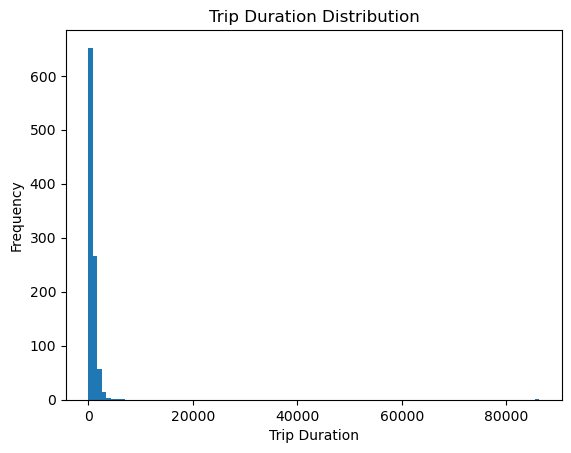

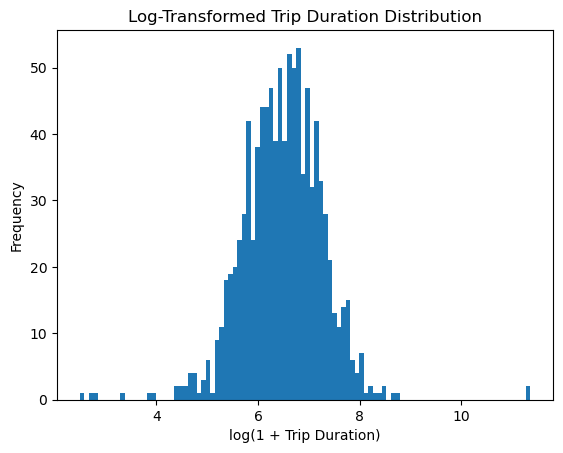

trip_duration 很可能是单位为秒 (seconds)


In [47]:
plt.hist(sampled_data['trip_duration'], bins=100)
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.title('Trip Duration Distribution')
plt.show()
log_duration = np.log1p(sampled_data['trip_duration'])  
plt.hist(log_duration, bins=100)
plt.xlabel('log(1 + Trip Duration)')
plt.ylabel('Frequency')
plt.title('Log-Transformed Trip Duration Distribution')
plt.show()

if sampled_data['trip_duration'].mean() < 2000:
    print("trip_duration 很可能是单位为秒 (seconds)")
else:
    print("trip_duration 数值偏大，可能是毫秒或存在异常值")

In [57]:
sampled_data = train.sample(n=1000, random_state=42)
filtered = sampled_data[sampled_data['trip_duration'] < 5000]
y = np.log1p(filtered['trip_duration'])
start = time. time ()
Xtr, Xv, ytr, yv = train_test_split (filtered[feature_names].values, y, test_size=0.2, random_state=1987)

# Create DMatrix, using np.inf as missing value marker
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
print(np.any(np.isinf(test)))
print(np.any(np.isnan(test))) 

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
xgb_pars = {
    'min_child_weight': 50, 
    'eta': 0.01, 
    'colsample_bytree': 0.3, 
    'max_depth': 10,
    'subsample': 0.8, 
    'lambda': 1, 
    'nthread': -1, 
    'booster': 'gbtree', 
    'verbosity': 1,
    'eval_metric': 'rmse', 
    'objective': 'reg:squarederror'
}

model = xgb.train(xgb_pars, dtrain, 500, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=1)
end = time. time
print("Modeling RMSLE %.5f" % model.best_score)

cv_results = xgb.cv(
    params=xgb_pars,
    dtrain=dtrain,
    num_boost_round=500,
    nfold=5, 
    early_stopping_rounds=50,
    metrics='rmse',
    as_pandas=True
)

print(cv_results)
y_pred = np.expm1(model.predict(dtest))
print("Predicted trip durations:", y_pred)

y_true = np.expm1(yv)  
y_pred = np.expm1(model.predict(dvalid))  
r2 = r2_score(y_true, y_pred)
print("R² score: %.5f" % r2)

#MAE
mae = mean_absolute_error(y_true, y_pred)
print("Validation MAE: %.2f seconds" % mae)
# RMSE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: %.2f seconds" % rmse)

False
False
[0]	train-rmse:5.94732	valid-rmse:6.00588
[1]	train-rmse:5.88866	valid-rmse:5.94682
[2]	train-rmse:5.83038	valid-rmse:5.88845
[3]	train-rmse:5.77286	valid-rmse:5.83083
[4]	train-rmse:5.71583	valid-rmse:5.77345
[5]	train-rmse:5.65941	valid-rmse:5.71665
[6]	train-rmse:5.60345	valid-rmse:5.66031
[7]	train-rmse:5.54823	valid-rmse:5.60475
[8]	train-rmse:5.49357	valid-rmse:5.55011
[9]	train-rmse:5.43946	valid-rmse:5.49604
[10]	train-rmse:5.38584	valid-rmse:5.44194
[11]	train-rmse:5.33277	valid-rmse:5.38858
[12]	train-rmse:5.27996	valid-rmse:5.33532
[13]	train-rmse:5.22802	valid-rmse:5.28325
[14]	train-rmse:5.17651	valid-rmse:5.23143
[15]	train-rmse:5.12549	valid-rmse:5.18028
[16]	train-rmse:5.07489	valid-rmse:5.12940
[17]	train-rmse:5.02492	valid-rmse:5.07907
[18]	train-rmse:4.97549	valid-rmse:5.02941
[19]	train-rmse:4.92656	valid-rmse:4.98005
[20]	train-rmse:4.87812	valid-rmse:4.93116
[21]	train-rmse:4.83016	valid-rmse:4.88280
[22]	train-rmse:4.78262	valid-rmse:4.83506
[23]	trai